# Audio Classifier for Capuchin Bird Calls

In [1]:
import torch
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import torchaudio
import torchvision
import random
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchinfo import summary
from tqdm.auto import tqdm

In [2]:
sns.set_theme()
torch.__version__, torchaudio.__version__, torchvision.__version__

('2.3.1', '2.3.1', '0.18.1')

In [3]:
# Setup device-agnostic code
if torch.cuda.is_available():
    device = "cuda"  # NVIDIA GPU
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    device = "mps"  # Apple GPU
else:
    device = "cpu"  # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

Using device: cuda


## TorchAudio Helper Functions

In [4]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

In [5]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

## Directories and File Paths

In [6]:
DATA_FOLDER = Path("../data")
CAPUCHIN_CLIPS_FOLDER = DATA_FOLDER / "Parsed_Capuchinbird_Clips"
NOT_CAPUCHIN_CLIPS_FOLDER = DATA_FOLDER / "Parsed_Not_Capuchinbird_Clips"
CAPUCHIN_CLIPS_FOLDER.exists(), NOT_CAPUCHIN_CLIPS_FOLDER.exists()

(True, True)

In [7]:
sample_capuchin_clip_path = random.choice(list(CAPUCHIN_CLIPS_FOLDER.iterdir()))
sample_not_capuchin_clip_path = random.choice(list(NOT_CAPUCHIN_CLIPS_FOLDER.iterdir()))
sample_capuchin_clip_metadata = torchaudio.info(sample_capuchin_clip_path)
sample_not_capuchin_clip_metadata = torchaudio.info(sample_not_capuchin_clip_path)
print(f"capuchin_clip: {sample_capuchin_clip_metadata}")
print(f"not_capuchin_clip: {sample_not_capuchin_clip_metadata}")

capuchin_clip: AudioMetaData(sample_rate=44100, num_frames=154350, num_channels=2, bits_per_sample=16, encoding=PCM_S)
not_capuchin_clip: AudioMetaData(sample_rate=44100, num_frames=143546, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [8]:
print(f"number of positive samples: {len(list(CAPUCHIN_CLIPS_FOLDER.iterdir()))}")
print(f"number of negative samples: {len(list(NOT_CAPUCHIN_CLIPS_FOLDER.iterdir()))}")

number of positive samples: 217
number of negative samples: 593


In [9]:
capuchin_clip_waveform, capuchin_clip_sample_rate = torchaudio.load(
    sample_capuchin_clip_path
)
print(torchaudio.info(sample_capuchin_clip_path))
not_capuchin_clip_waveform, not_capuchin_clip_sample_rate = torchaudio.load(
    sample_not_capuchin_clip_path
)
print(torchaudio.info(sample_not_capuchin_clip_path))
capuchin_clip_waveform.shape, not_capuchin_clip_waveform.shape

AudioMetaData(sample_rate=44100, num_frames=154350, num_channels=2, bits_per_sample=16, encoding=PCM_S)
AudioMetaData(sample_rate=44100, num_frames=143546, num_channels=2, bits_per_sample=16, encoding=PCM_S)


(torch.Size([2, 154350]), torch.Size([2, 143546]))

### Sample Capuchin Bird Call

In [10]:
Audio(capuchin_clip_waveform.numpy(), rate=capuchin_clip_sample_rate)

### Sample Not Capuchin Bird Call

In [11]:
Audio(not_capuchin_clip_waveform.numpy(), rate=not_capuchin_clip_sample_rate)

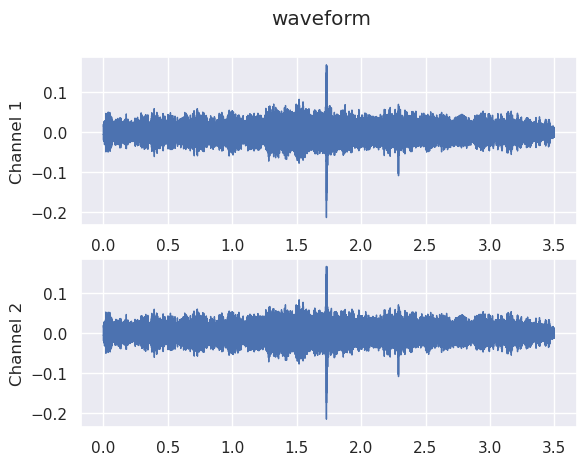

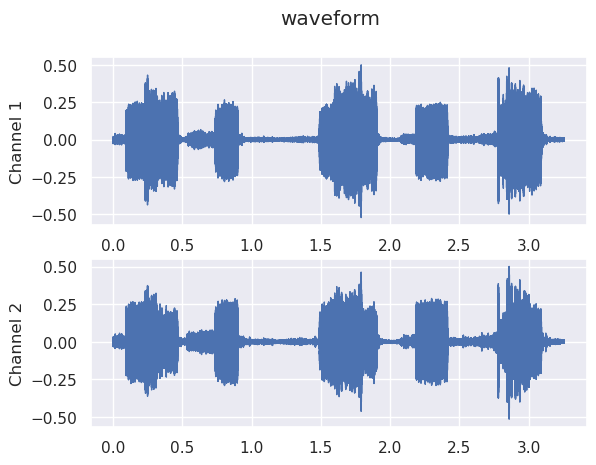

In [12]:
plot_waveform(capuchin_clip_waveform, capuchin_clip_sample_rate)
plot_waveform(not_capuchin_clip_waveform, not_capuchin_clip_sample_rate)

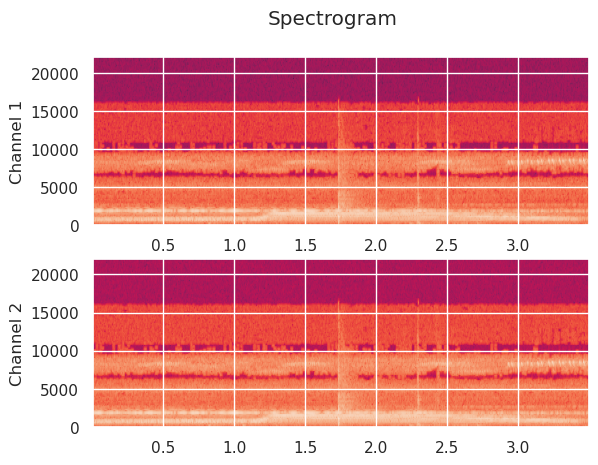

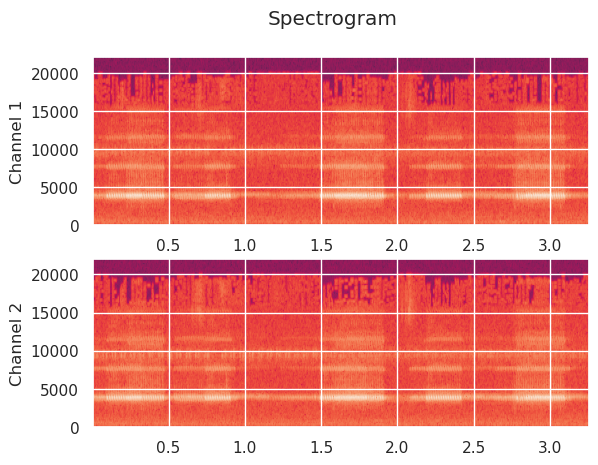

In [13]:
plot_specgram(capuchin_clip_waveform, capuchin_clip_sample_rate)
plot_specgram(not_capuchin_clip_waveform, not_capuchin_clip_sample_rate)

### Finding average clip length after resampling

In [14]:
capuchin_clips_paths = list(CAPUCHIN_CLIPS_FOLDER.iterdir())
resampler = torchaudio.transforms.Resample()
resampled_clips = [resampler(torchaudio.load(pth)[0]) for pth in capuchin_clips_paths]
capuchin_clip_lengths = [clip.shape[1] for clip in resampled_clips]
print(f"Maximum num of frames in capuchin clip {np.amax(capuchin_clip_lengths)}")
print(f"Average num of frames in capuchin clip {np.mean(capuchin_clip_lengths)}")
print(f"Minimum num of frames in capuchin clip {np.amin(capuchin_clip_lengths)}")

Maximum num of frames in capuchin clip 220500
Average num of frames in capuchin clip 149905.46543778802
Minimum num of frames in capuchin clip 22050


In [15]:
capuchin_clips_paths = list(CAPUCHIN_CLIPS_FOLDER.iterdir())
capuchin_clip_lengths = torch.Tensor(
    [torchaudio.info(pth).num_frames for pth in capuchin_clips_paths]
)
print(f"Maximum num of frames in capuchin clip {torch.max(capuchin_clip_lengths)}")
print(f"Average num of frames in capuchin clip {torch.mean(capuchin_clip_lengths)}")
print(f"Minimum num of frames in capuchin clip {torch.min(capuchin_clip_lengths)}")

Maximum num of frames in capuchin clip 220500.0
Average num of frames in capuchin clip 149905.453125
Minimum num of frames in capuchin clip 22050.0


In [16]:
NUM_FRAMES = 150000
SAMPLE_RATE = 16000
FRAME_OFFSET = 0

## Creating Custom PyTorch Dataset

In [17]:
class CapuchinBirdCallDataset(Dataset):
    def __init__(
        self,
        positive_folder: Path,
        negative_folder: Path,
        sample_rate: int,
        num_frames: int,
        frame_offset=0,
    ) -> None:
        super().__init__()
        self.sample_rate = sample_rate
        self.num_frames = num_frames
        self.frame_offset = frame_offset
        # load all clip paths into single sorted list
        positive_clips = list(positive_folder.iterdir())
        negative_clips = list(negative_folder.iterdir())
        clips = [
            (clip_path, torch.ones(1, dtype=torch.float32))
            for clip_path in positive_clips
        ]
        clips.extend(
            [
                (clip_path, torch.zeros(1, dtype=torch.float32))
                for clip_path in negative_clips
            ]
        )
        clips.sort(key=lambda item: item[0])
        self.clips = clips

        self.gen_spectrogram = torchaudio.transforms.Spectrogram(n_fft=800)

    def load_mono_audio(self, clip_path: Path) -> torch.Tensor:
        clip_waveform, clip_sample_rate = torchaudio.load(
            clip_path,
            frame_offset=self.frame_offset,
            num_frames=self.num_frames,
        )
        # only get the first channel
        clip_waveform = clip_waveform[0, :].unsqueeze(0)
        # resample the clip
        resampled_clip = torchaudio.functional.resample(
            clip_waveform, clip_sample_rate, self.sample_rate
        )
        # pad the clip if necessary
        if resampled_clip.shape[1] < self.num_frames:
            zero_padding = torch.zeros((1, self.num_frames - resampled_clip.shape[1]))
            resampled_clip = torch.concat((resampled_clip, zero_padding), dim=1)
        return resampled_clip

    def __len__(self) -> int:
        return len(self.clips)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, int]:
        clip_path, label = self.clips[index]
        resampled_clip = self.load_mono_audio(clip_path)
        spectrogram = self.gen_spectrogram(resampled_clip)
        # stack the spectrogram for rgb input
        spectrogram = spectrogram.expand(3, -1, -1)
        return spectrogram, label

### Spectrogram Sample of Capuchin Bird

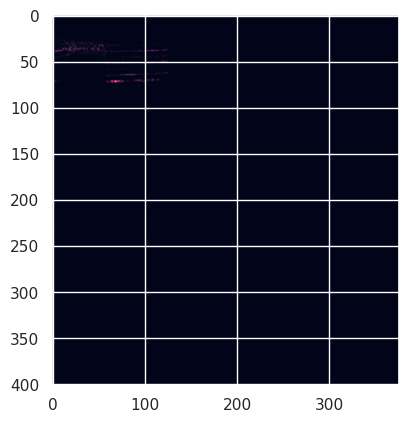

In [18]:
capuchin_call_dataset = CapuchinBirdCallDataset(
    CAPUCHIN_CLIPS_FOLDER, NOT_CAPUCHIN_CLIPS_FOLDER, SAMPLE_RATE, NUM_FRAMES
)
sample = capuchin_call_dataset.__getitem__(8)
plt.imshow(sample[0][0].squeeze().numpy())
plt.show()

### Spectrogram Sample of Not Capuchin Bird

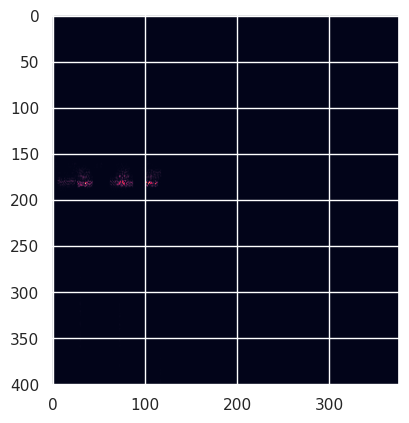

In [19]:
sample = capuchin_call_dataset.__getitem__(400)
plt.imshow(sample[0][0].squeeze().numpy())
plt.show()

## Creating train and test dataloaders

In [20]:
train_test_split_generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = torch.utils.data.random_split(
    capuchin_call_dataset, [0.8, 0.2], generator=train_test_split_generator
)

In [21]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=32, num_workers=8, shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_dataset, batch_size=32, num_workers=8, shuffle=True
)

In [22]:
spectrogram_sample, label_sample = next(iter(train_dataloader))
spectrogram_sample.shape, label_sample.shape

(torch.Size([32, 3, 401, 376]), torch.Size([32, 1]))

In [23]:
input_shape = spectrogram_sample.shape

## Creating the model

In [24]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
summary(
    model=model,
    input_size=input_shape,  # make sure this is "input_size", not "input_shape"
    # col_names=["input_size"], # uncomment for smaller output
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 401, 376]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 401, 376]    [32, 1280, 13, 12]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 401, 376]    [32, 32, 201, 188]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 401, 376]    [32, 32, 201, 188]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 201, 188]   [32, 32, 201, 188]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 201, 188]   [32, 32, 201, 188]   --                   --
│    └─Sequential (1)                                        [32, 32, 201, 188]   [32, 16, 201

### Freezing the base model and changing the classifier for our needs

In [25]:
for param in model.features.parameters():
    param.requires_grad = False

In [26]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = 1

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=500, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=500, out_features=1, bias=True),
).to(device)

In [27]:
summary(
    model=model,
    input_size=input_shape,  # make sure this is "input_size", not "input_shape"
    # col_names=["input_size"], # uncomment for smaller output
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 401, 376]    [32, 1]              --                   Partial
├─Sequential (features)                                      [32, 3, 401, 376]    [32, 1280, 13, 12]   --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 401, 376]    [32, 32, 201, 188]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 401, 376]    [32, 32, 201, 188]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 201, 188]   [32, 32, 201, 188]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 201, 188]   [32, 32, 201, 188]   --                   --
│    └─Sequential (1)                                        [32, 32, 201, 188]   [32, 

## Training the model

In [28]:
# Define loss and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
torch.manual_seed(42)
epochs = 5

sigmoid = torch.nn.Sigmoid()

# Create training and testing loop
for epoch in range(epochs):
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    with tqdm(
        enumerate(train_dataloader), unit="batch", total=len(train_dataloader)
    ) as tepoch:
        for batch, (X, y) in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            X = X.to(device)
            y = y.to(device)

            model.train()

            y_logits = model(X)
            y_pred = sigmoid(y_logits)

            loss = loss_fn(y_logits, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        ### Testing
        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X = X.to(device)
                y = y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)

            test_loss /= len(test_dataloader)
        print(f"Epoch: {epoch} | Test loss: {test_loss}")

  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 0 | Test loss: 0.4513814449310303


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 1 | Test loss: 0.16963307559490204


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 2 | Test loss: 0.14757512509822845


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 3 | Test loss: 0.09061391651630402


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 4 | Test loss: 0.0904817134141922
